Did you experiment in Steps 1 and 2 using different parameter choices? If you did, you probably ran into some unexpected behavior. Did your solution ever blow up? 

You are probably wondering why changing the discretization parameters affects your solution in such a drastic way. 

Step 3: Convergence and the CFL Condition
-----
***

Three more specific questions:
1. Why does the numerical solution tend to diffuse compared to the analytical solution?
2. Why is it necessary for the CFL number to remain below 1?
3. What causes a numerical solution to diverge when the velocity c is negative?

For the first few steps, we've been using the same general initial and boundary conditions.  With the parameters we initially suggested, the grid has 41 points and the timestep is 0.025 seconds.  Now, we're going to experiment with increasing the size of our grid.  The code below is identical to the code we used in Step 1, but here it has been bundled up in a function so that we can easily examine what happens as we adjust just one variable: **the grid size**.

In [1]:
import numpy as np               #numpy is a library for array operations akin to MATLAB
from matplotlib import pyplot as plt    #matplotlib is 2D plotting library


def linearconv(nx):
    dx = 2/(nx - 1)
    nt = 20     #nt is the number of timesteps we want to calculate
    dt = 0.025  #dt is the amount of time each timestep covers (delta t)
    c = 1
    
    u = np.ones(nx)  #defining a numpy array which is nx elements long with every value equal to 1
    u[int(0.5/dx):int(1/dx+1)] = 2  #setting u = 2 between 0.5 and 1 as per our I.C.s
    
    un = np.ones(nx) #initializing our placeholder array, un, to hold the values we calculate for the n+1 timestep
    
    for n in range(nt): #iterate through time
        un = u.copy() #copy the existing values of u into un
        for i in range(1, nx):
            u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
            
    plt.plot(np.linspace(0,2,nx),u)
    print("CFL number =", c*dt/dx)  # We will explain the meaning of CFL soon

CFL number = 0.5


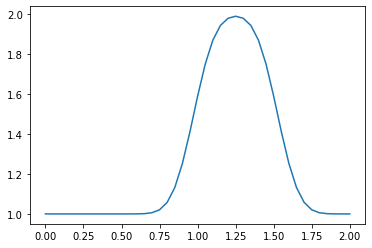

In [2]:
linearconv(41)
#This is the same result as our Step 1 calculation, reproduced here for reference.

CFL number = 0.75


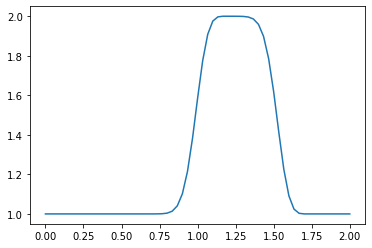

In [3]:
linearconv(61)
#Here, there is still numerical diffusion present, but it is less severe.  

CFL number = 1.0


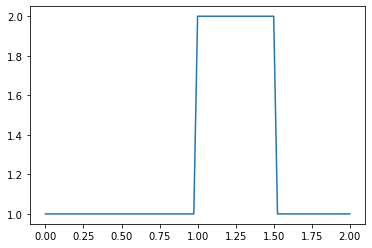

In [4]:
linearconv(81)
#The wave is much more square than in the previous runs.

CFL number = 1.125


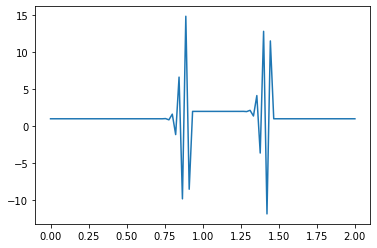

In [5]:
linearconv(91)
#This doesn't look anything like our original hat function. 
#The result blows up

### What happened?
--------
To answer that question, we have to think a little bit about what we're actually implementing in code.  

In each iteration of our time loop, we use the existing data about our wave to estimate the speed of the wave in the subsequent time step.  Initially, the increase in the number of grid points returned more accurate answers.  There was less numerical diffusion and the square wave looked much more like a square wave than it did in our first example.  

Each iteration of our time loop covers a time-step of length $\Delta t$, which we have been defining as 0.025

During this iteration, we evaluate the speed of the wave at each of the $x$ points we've created.  In the last plot, something has clearly gone wrong.  

What has happened is that over the time period $\Delta t$, the wave is travelling a distance which is greater than `dx`.  The length `dx` of each grid box is related to the number of total points `nx`, so stability can be enforced if the $\Delta t$ step size is calculated with respect to the size of `dx`.  

$$\sigma = \frac{u \Delta t}{\Delta x} \leq \sigma_{\max}$$

where $u$ is the speed of the wave; $\sigma$ is called the **Courant number** and the value of $\sigma_{\max}$ that will ensure stability depends on the discretization used. 

In a new version of our code, we'll use the CFL number to calculate the appropriate time-step `dt` depending on the size of `dx`.  

In [6]:
import numpy
from matplotlib import pyplot

def linearconv(nx):
    dx = 2 / (nx - 1)
    nt = 20    #nt is the number of timesteps we want to calculate
    c = 1
    CFL = 0.9   #the Courant number is always equal to 0.9
    
    dt = CFL * dx / c  # compute dt based on Courant number

    u = numpy.ones(nx) 
    u[int(.5/dx):int(1 / dx + 1)] = 2

    un = numpy.ones(nx)

    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nx):
            u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
        
    pyplot.plot(numpy.linspace(0, 2, nx), u)
    print("CFL number =", c*dt/dx)
    print("dt =", dt)

CFL number = 0.9
dt = 0.045000000000000005


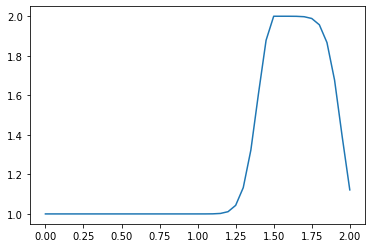

In [7]:
linearconv(41)

CFL number = 0.9
dt = 0.03


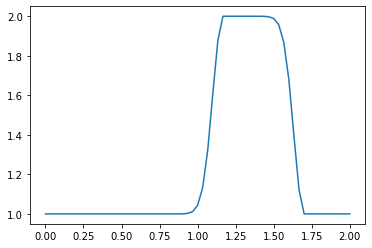

In [8]:
linearconv(61)

CFL number = 0.9
dt = 0.022500000000000003


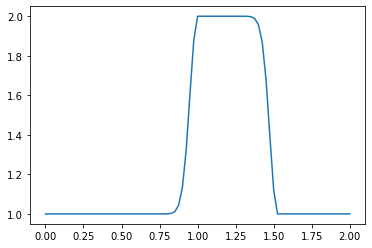

In [9]:
linearconv(81)

CFL number = 0.9000000000000001
dt = 0.018000000000000002


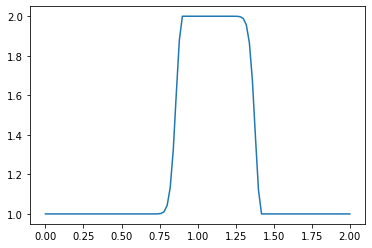

In [10]:
linearconv(101)

CFL number = 0.9000000000000001
dt = 0.009000000000000001


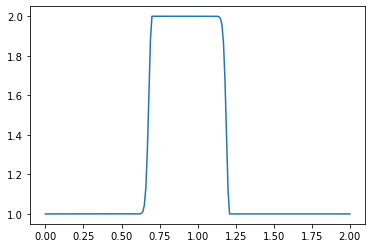

In [11]:
linearconv(201)

Notice that as the number of points `nx` increases, the wave convects a shorter and shorter distance.  The number of time iterations we have advanced the solution at is held constant at `nt = 20`, but depending on the value of `nx` and the corresponding values of `dx` and `dt`, a shorter time window is being examined overall.  

Next, we will employ the upwind scheme to accommodate both scenarios where c is positive and negative.

In [12]:
def linearconv_c(nx, c):
    dx = 2 / (nx - 1)
    nt = 20    #nt is the number of timesteps we want to calculate
    c = c
    
    dt = 0.018  # compute dt based on Courant number

    u = numpy.ones(nx) 
    u[int(.5/dx):int(1 / dx + 1)] = 2

    un = numpy.ones(nx)

    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nx):
            u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
        
    pyplot.plot(numpy.linspace(0, 2, nx), u)
    print("CFL number =", c*dt/dx)
    print("dt =", dt)

CFL number = -0.8999999999999999
dt = 0.018


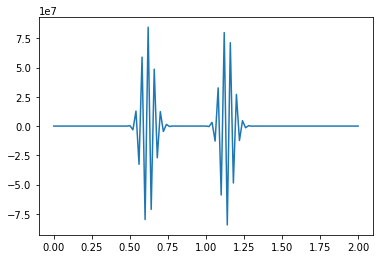

In [13]:
linearconv_c(101,-1)

In [14]:
def upwind_c(nx, c):
    dx = 2 / (nx - 1)
    nt = 20    #nt is the number of timesteps we want to calculate
    c = c
    
    dt = 0.018  # compute dt based on Courant number

    u = numpy.ones(nx) 
    u[int(.5/dx):int(1 / dx + 1)] = 2

    un = numpy.ones(nx)
    #'''Choose which nodes to use for differencing based on the direction of
    #velocity on the interface to always use information from upstream nodes
    F = lambda c: (max(c/(abs(c)+1e-6), 0), max(-c/(abs(c)+1e-6), 0))
    #You can try to let c = 0.0 and see what is going on
    
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        
        for i in range(1, nx-1):
            # Coefficients to the east side of the node (i+1)
            fe1, fe2 = F(c)
            # Coefficients to the west side of the node (i-1)
            fw1, fw2 = F(c)
            # Differential values on the east side interface
            ue = un[i] * fe1 + un[i+1] * fe2
            # Differential values on the wast side interface
            uw = un[i-1] * fw1 + un[i]* fw2
            u[i] = un[i] - c * dt / dx * (ue - uw)
        #for i in range(1, nx):
            #u[i] = un[i] - c * dt / dx * (un[i] - un[i-1])
        
    pyplot.plot(numpy.linspace(0, 2, nx), u)
    print("CFL number =", c*dt/dx)
    print("dt =", dt)

CFL number = -0.8999999999999999
dt = 0.018


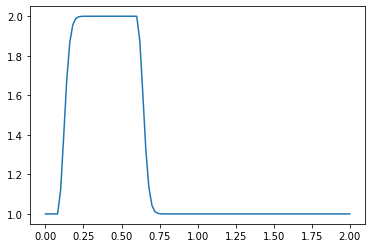

In [15]:
upwind_c(101,-1)